# Mapping Short-Term Rental Patterns and Housing Pressure Signals in Cape Town

**Notebook 2: Data Cleaning & Preprocessing**

**Purpose:**  
This notebook builds on **Notebook 1: Data Preview**, where the raw Airbnb datasets were inspected for structure, missing values, duplicates, and extreme price outliers.  

In **Notebook 2: Data Cleaning & EDA**, the data is cleaned, standardised, and preprocessed to prepare it for spatial analysis, aggregation, and visualization.

The cleaned datasets will feed into **Notebook 3: Spatial Analysis**, where short-term rental activity and neighbourhood-level housing pressure indicators will be constructed.

## 1. Common notebook setup
### 1.1 Import required libraries

In [2]:
# Import libraries
import sys
sys.path.append("..") # Move up project root to import config
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import geopandas as gpd

# Enable inline plotting (for Jupyter)
%matplotlib inline

# Import config file
import config

### 1.2 Color palette and styling

In [3]:
# Define the color palette
palette = ["#68174c", "#df586a", "#fd9c74", "#fdc48e", "#ffebc8"]

# Set Seaborn styling
sns.set_style("whitegrid")
sns.set_palette(palette)

# Set Matplotlib rcParams for consistent styling
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['axes.labelweight'] = 'bold'
mpl.rcParams['font.family'] = 'DejaVu Serif'

### 1.3 Define helper functions

In [4]:
# Helper function to load files
def load_csv(path, compression=None, name="Dataset"):
    """ Load CSV with optional compression and display message."""
    if os.path.exists(path):
        df = pd.read_csv(path, compression=compression)
        if df.empty:
            print(f"{name} loaded but is empty.")
        else:
            print(f"{name} loaded successfully.")
        return df
    else:
        print(f"{name} not found: {path}")
        return None

    
# Helper function to check for missing values
def check_missing_data(df, name="Dataset"):
    missing_values = df.isnull().sum().reset_index()
    missing_values.columns = ["Column", "Missing Values"]
    missing_values["% Missing"] = (missing_values["Missing Values"] / 
                                   len(df) * 100).round(2)
    total_missing = missing_values["Missing Values"].sum()

    if total_missing == 0:
        print(f"No missing data found in {name}.")
    else:
        print(f"Missing data summary for {name}:")
        print(missing_values[missing_values["Missing Values"] > 0])

### 1.4 Load the datasets

In [5]:
# Define path to the dataset
filepath_listings = config.LISTINGS_FILE
filepath_calendar = config.CALENDAR_FILE
filepath_gdf = config.GDF_FILE

# Load listings
listings_df = load_csv(filepath_listings, name="Listings")

# Load calendar
calendar_df = load_csv(filepath_calendar, compression="gzip", name="Calendar")

# Load neighbourhoods
wards_gdf = gpd.read_file(filepath_gdf)

Listings loaded successfully.
Calendar loaded successfully.


## 2. Preprocessing Listings and Calendar Datasets
A structured preprocessing workflow is applied to both the listings and calendar datasets to prepare them for analysis.  
This includes removing irrelevant or empty columns, standardising data types (such as converting dates and booleans), imputing missing values where appropriate, and eliminating duplicate records.  
The neighbourhoods GeoDataFrame is also checked for completeness and coordinate reference system consistency to ensure alignment with later spatial analysis.

### 2.1 Listings Dataset Cleaning

In [6]:
# Drop irrelevant columns
listings_df = listings_df.drop(columns=['neighbourhood_group', 'license'])

# Fill missing str/object columns
listings_df['name'] = listings_df['name'].fillna("Unknown")
listings_df['host_name'] = listings_df['host_name'].fillna("Unknown")

# Fill missing numeric columns
listings_df['price'] = listings_df['price'].fillna(
    listings_df['price'].median())

listings_df['reviews_per_month'] = listings_df['reviews_per_month'].fillna(0)

# Convert data types
listings_df['id'] = listings_df['id'].astype(int)
listings_df['last_review'] = pd.to_datetime(listings_df['last_review'], 
                                            errors='coerce')

# Drop duplicates
listings_df = listings_df.drop_duplicates()

C:\Users\namit\AppData\Local\Temp\ipykernel_17548\2547939808.py:16: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  listings_df['last_review'] = pd.to_datetime(listings_df['last_review'],


### 2.2 Calendar Dataset Cleaning

In [7]:
# Convert date to datetime
calendar_df['date'] = pd.to_datetime(calendar_df['date'], errors='coerce')

# Convert available to boolean
calendar_df['available'] = calendar_df['available'].map({'t': True, 'f': False})

# Drop duplicates
calendar_df = calendar_df.drop_duplicates()

# Preview cleaned datasets
print("Listings cleaned shape:", listings_df.shape)
print("Calendar cleaned shape:", calendar_df.shape)

Listings cleaned shape: (26877, 16)
Calendar cleaned shape: (9810109, 7)


### 2.3 Neighbourhoods Dataset Cleaning

In [8]:
# Check Coordinate Reference System (CRS)
print("Neighbourhoods GeoDataFrame CRS:", wards_gdf.crs)

# Drop empty column
if 'neighbourhood_group' in wards_gdf.columns:
    wards_gdf = wards_gdf.drop(columns=['neighbourhood_group'])
print("\nDropped 'neighbourhood_group' column (100% missing values).\n")

# Confirm final structure
wards_gdf.info()

Neighbourhoods GeoDataFrame CRS: EPSG:4326

Dropped 'neighbourhood_group' column (100% missing values).

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   neighbourhood  116 non-null    object  
 1   geometry       116 non-null    geometry
dtypes: geometry(1), object(1)
memory usage: 1.9+ KB


**Observations and Insights**
- In the listings dataset, columns with large missing values and irrelevant data (i.e.'neighbourhood_group' and 'license') were dropped.  
- Missing values in 'price' and 'reviews_per_month' were imputed and duplicate rows were removed.  
- Extreme prices (> R100,000) were filtered to reduce skew in price-related visualizations. The full price range (~R161 to ~R714,000) indicates potential luxury listings or data entry errors, which highlights the need to identify outliers.  
- In the calendar dataset, complete columns were retained, while columns with significant missing values ('price' and 'adjusted_price') were observed. Therefore analysis will focus primarily on availability patterns.  
- To prepare for aggregation, occupancy calculation, and time-based analysis, the 'date' and 'available' columns in calendar dataset were converted to datetime and boolean, respectively.

## 3. Exploratory Data Analysis (EDA)
### 3.1 Price distribution
Preliminary analysis of listing prices shows a very wide range. To understand the distribution, first the prices are segmented into bins, then rare/luxury listings are identifed and finally the focus is placed on the price range accomodatng the majority of listings for visual analysis.

In [9]:
# Display the full price range in the dataset
print(f"Price range: R{listings_df['price'].min()} -"
      f"R{listings_df['price'].max()}")

# Create 10 equal width segments within the full price range
price_segments = np.linspace(listings_df['price'].min(),
                             listings_df['price'].max(),11)

labels = [f"R{int(price_segments[i])} - R{int(price_segments[i+1])}" 
          for i in range(len(price_segments)-1)]

listings_df['price_segment'] = pd.cut(listings_df['price'], 
                                      bins=price_segments, 
                                      labels=labels, 
                                      include_lowest=True)

# Count and percentage per segment
price_segments_summary = listings_df[
    'price_segment'].value_counts().sort_index()
percentage_per_segment = (price_segments_summary/
                          len(listings_df) * 100).round(2)

price_distribution = pd.DataFrame({'count': price_segments_summary, 
                                   'percentage': percentage_per_segment})

# Display price distribution of the dataset
price_distribution

Price range: R161.0 -R714885.0


,count,percentage
price_segment,,
R161 - R71633,26826,99.81
R71633 - R143105,38,0.14
R143105 - R214578,8,0.03
R214578 - R286050,2,0.01
R286050 - R357523,2,0.01
R357523 - R428995,0,0.00
R428995 - R500467,0,0.00
R500467 - R571940,0,0.00
R571940 - R643412,0,0.00


- The full price range of listings is R161 – R714,885.
- Using 10 equal-width segments, ~99.8% of listings fall in the first segment (R161 – R71,633), representing the majority of listings.  
- The remaining listings (~0.2%) must be rare/luxury listings (or errors in data entry) and could skew visualizations and analysis.
- For focused EDA, the dataset is filtered to the majority segment (R ≤ 71,633).
- To focus on the affordability-relevant segment, listings above R71,633 are temporarily excluded from visual analysis, as they represent less than 0.2% of the market and could skew distributions.

Number of outliers within majority listings: 3258(12.14%)


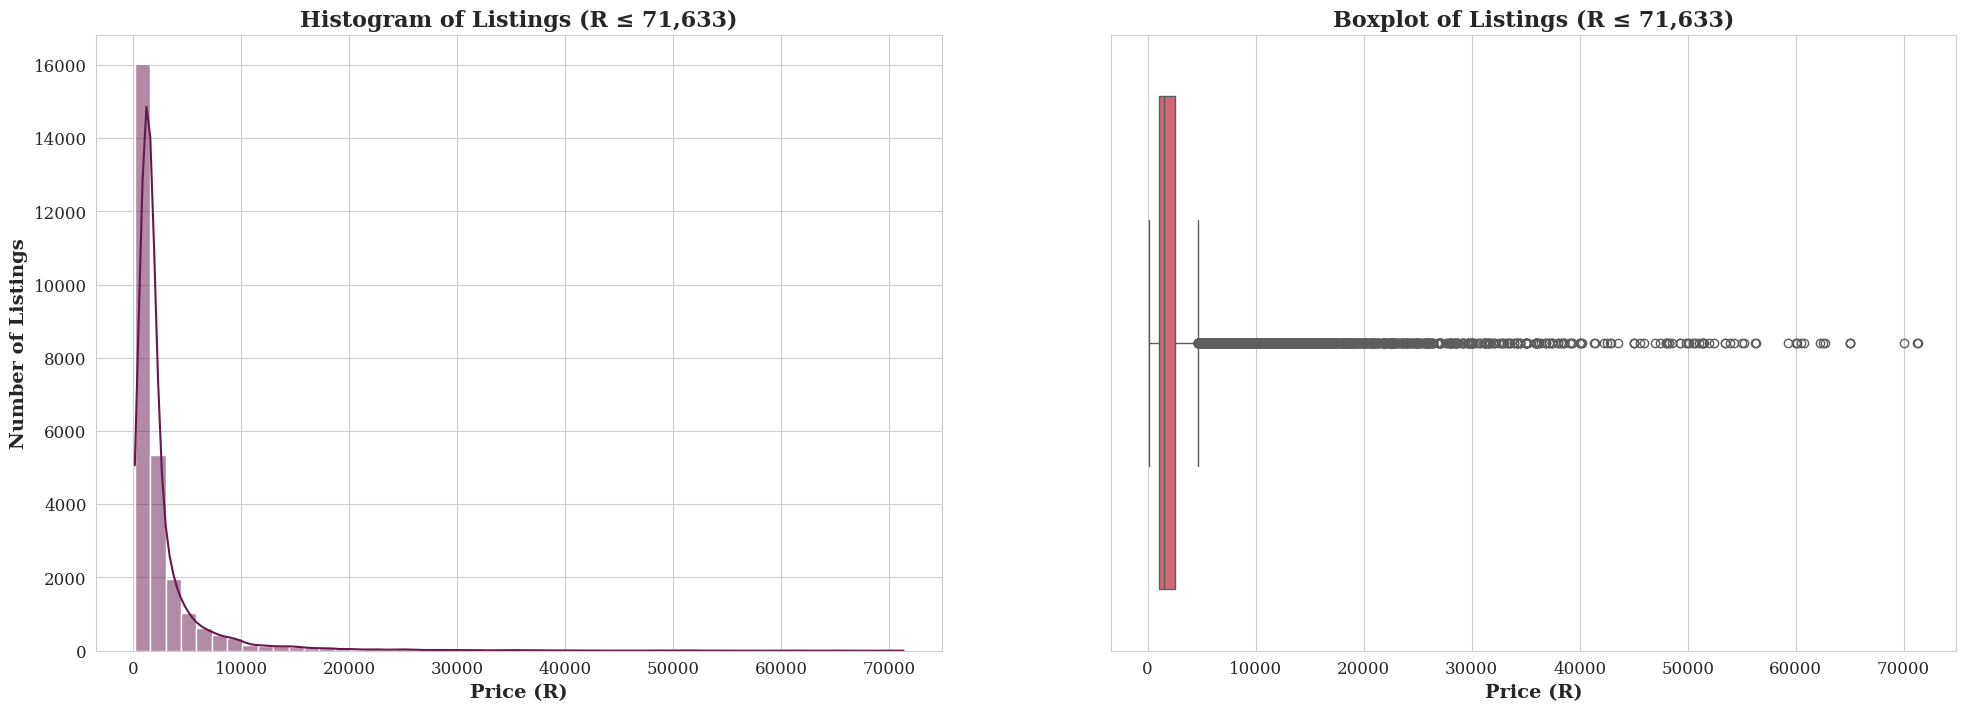

In [15]:
# Filter dataset to focus on majority listings
majority_df = listings_df[listings_df['price'] <= 71633]

# Identify statistical outliers within the majority segment using IQR
Q1 = majority_df['price'].quantile(0.25)
Q3 = majority_df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = majority_df[(majority_df['price'] < lower_bound) | 
                       (majority_df['price'] > upper_bound)]

# Display the number and percentage of outliers
print(f"Number of outliers within majority listings: "
      f"{len(outliers)}({len(outliers)/len(majority_df)*100:.2f}%)")

# Plot boxplot and distribution for the majority listings
fig, axes = plt.subplots(1,2,figsize=(24,8))

# Histogram for majority listings
sns.histplot(majority_df['price'], bins=50, kde=True, 
             ax=axes[0],color=palette[0])
axes[0].set_title("Histogram of Listings (R ≤ 71,633)")
axes[0].set_xlabel("Price (R)")
axes[0].set_ylabel("Number of Listings")

# Boxplot for majority listings
sns.boxplot(x='price', data=majority_df, showfliers=True, 
            ax=axes[1], color=palette[1])
axes[1].set_title("Boxplot of Listings (R ≤ 71,633)")
axes[1].set_xlabel("Price (R)")
plt.show()
plt.close()

**Observations & Insights**
- Even after filtering to the majority segment (R ≤ 71,633), 12.1% of listings are statistical outliers based on the IQR method.
- These outliers represent higher-than-typical prices within the majority segment, but they are still far below the ultra-luxury listings (> R71,633) that were excluded earlier.
- Including them in visualizations (boxplot and histogram) helps capture the full spread of typical listings without letting extreme luxury listings distort the patterns.
- This filtered dataset is now suitable for further EDA, like analyzing room types and neighbourhoods, while keeping the focus on affordability-relevant listings.

### 3.2 Distribution by property typology
The distribution of property typology is examined (i.e.'room_type') to understand the types of accommodations available on Airbnb in Cape Town and how pricing varies across them.

In [11]:
# Count of listings per room type
room_counts = majority_df['room_type'].value_counts()
room_percent = (room_counts / len(majority_df) * 100).round(2)

room_distribution = pd.DataFrame({'count': room_counts, 'percentage': room_percent})
room_distribution

,count,percentage
room_type,,
Entire home/apt,22128,82.49
Private room,4541,16.93
Hotel room,112,0.42
Shared room,45,0.17


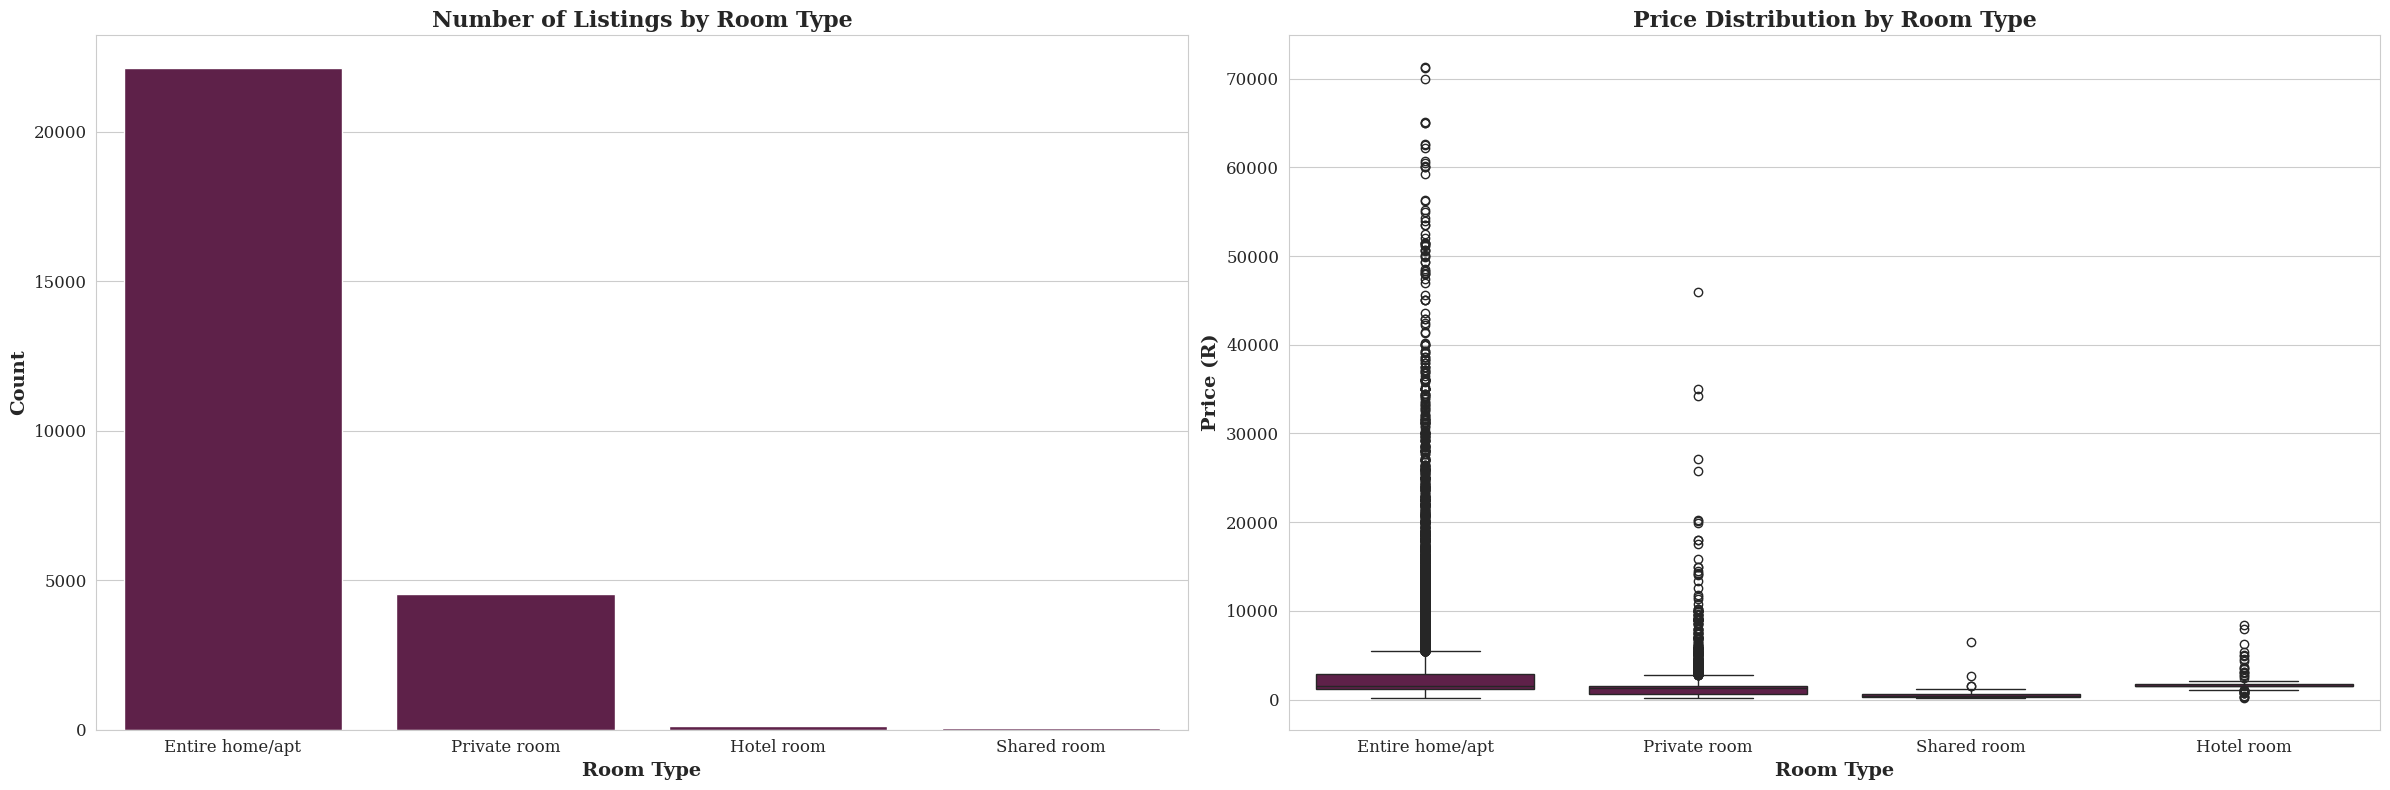

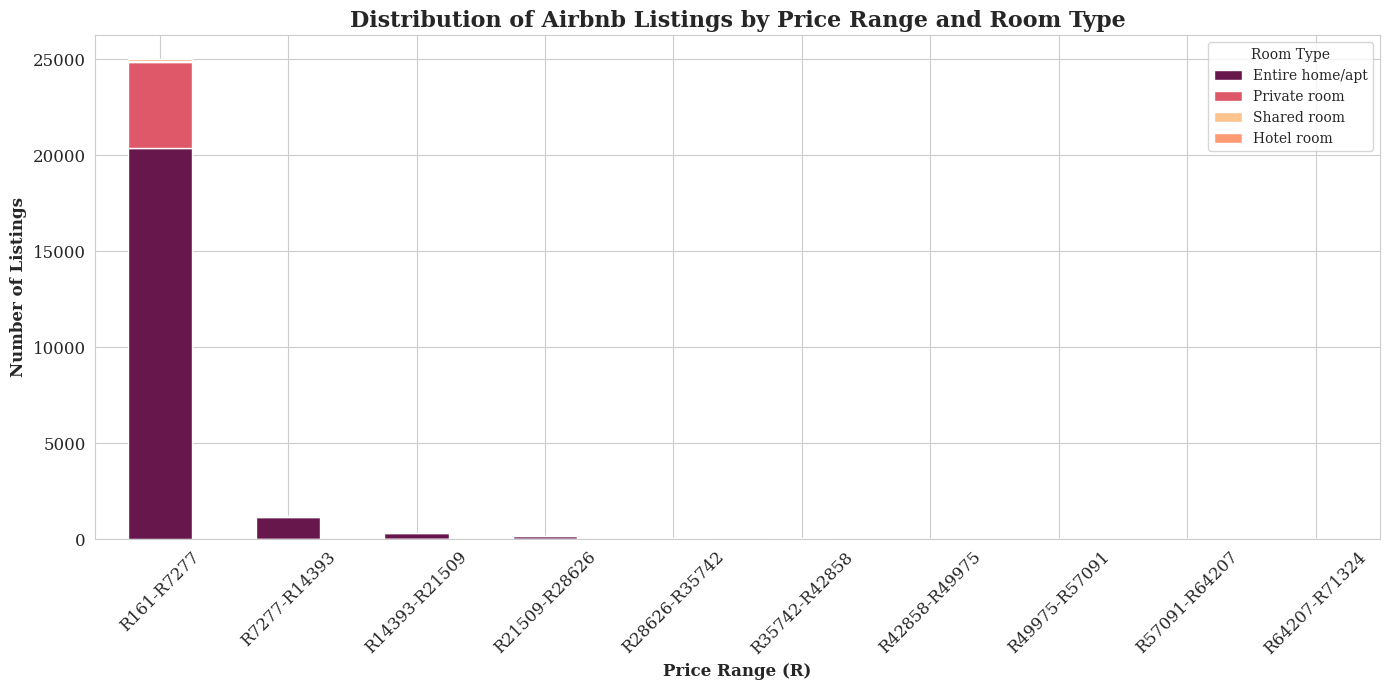

In [16]:
# Subplot layout
fig,axes = plt.subplots(1,2,figsize = (24,8))

# Plot count of room types 
room_counts = majority_df['room_type'].value_counts().reset_index()
room_counts.columns = ['room_type','count']

sns.barplot(data=room_counts, x= 'room_type',y='count', ax = axes[0])
axes[0].set_title("Number of Listings by Room Type")
axes[0].set_xlabel("Room Type")
axes[0].set_ylabel("Count")

# Plot price distribution by room type
sns.boxplot(data=majority_df, x='room_type', y='price', ax=axes[1])
axes[1].set_title("Price Distribution by Room Type")
axes[1].set_xlabel("Room Type")
axes[1].set_ylabel("Price (R)")

plt.tight_layout()
plt.show()
plt.close()

# Price range bins by type
# Define price bins
price_bins = np.linspace(majority_df['price'].min(), majority_df['price'].max(), 11)
price_labels = [f"R{int(price_bins[i])}-R{int(price_bins[i+1])}" for i in range(len(price_bins)-1)]

# Compute counts per price bin and room type
price_counts = {}
for room in majority_df['room_type'].unique():
    counts = pd.cut(
        majority_df[majority_df['room_type'] == room]['price'],
        bins=price_bins
    ).value_counts().sort_index()
    price_counts[room] = counts.values

# Create DataFrame
price_counts_df = pd.DataFrame(price_counts, index=price_labels)


# Map palette to room types
room_pallete = {"Entire home/apt": palette[0], 
                "Private room": palette[1], 
                "Hotel room": palette[2], 
                "Shared room": palette[3]}

# Plot stacked bar chart
ax = price_counts_df.plot(
    kind='bar', 
    stacked=True, 
    figsize=(14,7),
    color = [room_pallete[room] for room in price_counts_df.columns]
)

plt.title("Distribution of Airbnb Listings by Price Range and Room Type", fontsize=16)
plt.xlabel("Price Range (R)", fontsize=12)
plt.ylabel("Number of Listings", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Room Type", fontsize=10)
plt.tight_layout()

plt.show()
plt.close()

**Observations & Insights**
- 'Entire home/apt' typology dominates the market, representing ~82.5% of listings, suggesting that the majority of Airbnb activity in Cape Town involves full-property rentals rather than shared spaces.
- Private rooms (16.9%), though fewer, show a wider spread across mid-to-high price ranges, indicating that some private-room listings are priced unusually high, possibly due to premium locations, amenities, or small guesthouse setups.
- Hotel rooms (~0.4%) and shared rooms (0.17%) are rare and unlikely to impact overall affordability trends.
- The imbalance in typology indicates that affordability pressures are more likely to be driven by entire homes and apartments, which can influence the reduction in long-term housing availability for residents.
- Overall, the typology distribution highlights a market oriented towards tourist-focused, full-unit rentals rather than local, community-based sharing models.

### 3.3 Neighbourhood Trends

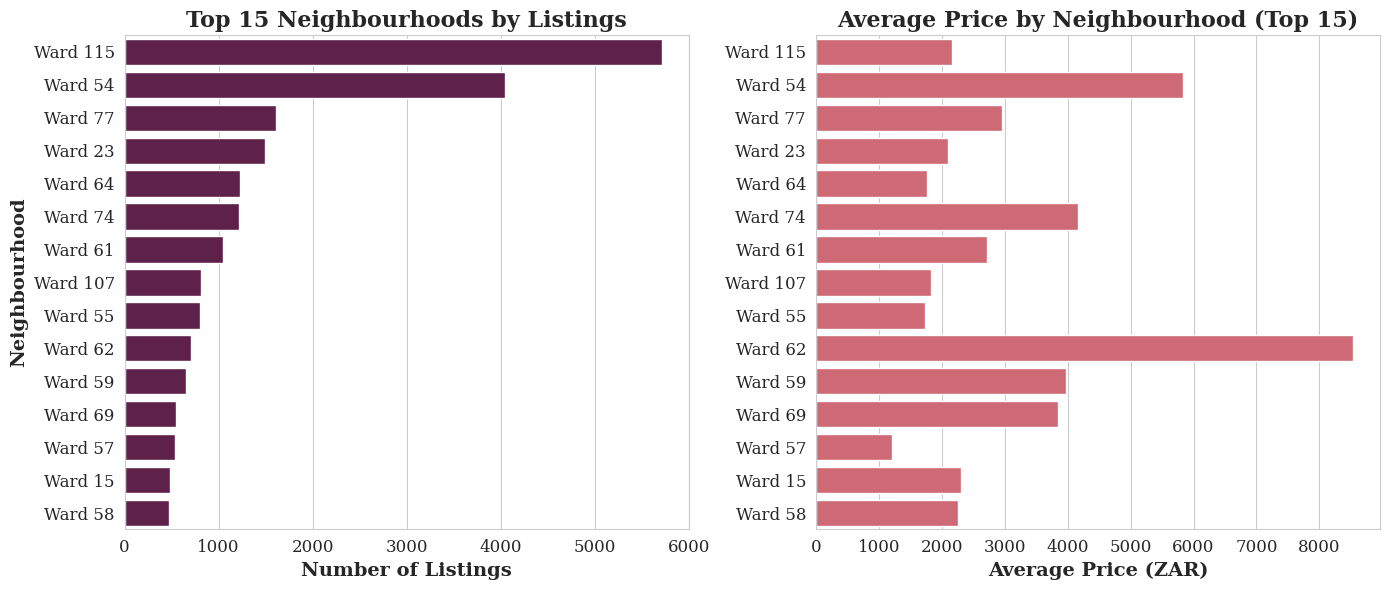

In [17]:
# Top 15 neighbourhoods by listing count
top_wards = listings_df['neighbourhood'].value_counts().head(15)
top_ward_names = top_wards.index

# Average price only for those 15
ward_price = listings_df.groupby('neighbourhood')['price'].mean().loc[
    top_ward_names]

# Subplot layout
fig, ax = plt.subplots(1, 2, figsize=(14,6))

# Plot 1: Listing counts
sns.barplot(y=top_wards.index, x=top_wards.values, 
            ax=ax[0], color=palette[0])
ax[0].set_title("Top 15 Neighbourhoods by Listings")
ax[0].set_xlabel("Number of Listings")
ax[0].set_ylabel("Neighbourhood")

# Plot 2: Average price
sns.barplot(y=ward_price.index, x=ward_price.values, 
            ax=ax[1], color=palette[1])
ax[1].set_title("Average Price by Neighbourhood (Top 15)")
ax[1].set_xlabel("Average Price (ZAR)")
ax[1].set_ylabel("")

plt.tight_layout()
plt.show()
plt.close()

**Observations**
- Ward 115 has the most listings (5,715) but a moderate average price (R2,169). 
- Ward 62 has fewer listings (711) but the highest average price (R8,536).
- Some moderate-density wards (Ward 54, Ward 74) have high prices, indicating potential affordability pressure.
- Lower-density wards (Ward 57, Ward 55) remain relatively affordable.
- High listing counts do not always correspond to high prices; both metrics are needed to identify pressure points.

## 4. Summary of insights from EDA

- The Cape Town Airbnb market is dominated by entire homes/apartments (~82.5%), with private rooms (~16.9%) contributing modestly, and hotel/shared rooms remaining rare (<1%). This indicates a market oriented toward full-unit tourist rentals rather than shared, community-based spaces.
- Private rooms show a broad price spread, with some positioned in higher ranges, likely due to premium locations or additional amenities.
- Within the majority price segment (R ≤ 71,633), most listings are affordable, but statistical outliers remain, indicating exceptionally high prices even within non-luxury listings.
- Neighbourhood patterns reveal that high listing counts do not always correspond to high prices. For example: 
  - **Ward 115**: highest listing count (5,715) but moderate average price (R2,169).  
  - **Ward 62**: fewer listings (711) but highest average price (R8,536).  
- High-density wards such as Ward 115 may experience affordability pressure due to cumulative short-term rental activity, even if prices are not the highest.
- Moderate-density wards (e.g., Ward 54, Ward 74) display elevated price levels, while lower-density wards (Ward 55, Ward 57) remain more affordable.
- Overall, short-term rental pressure is concentrated in popular wards with high listing density and dominance of entire-home listings, which could reduce long-term housing availability for residents.


## 5. Save cleaned data

In [14]:
os.makedirs("data/processed", exist_ok=True)

listings_df.to_csv("data/processed/listings_clean.csv", index=False)
majority_df.to_csv("data/processed/majority_listings_clean.csv", index=False)
calendar_df.to_csv("data/processed/calendar_clean.csv", index=False)
wards_gdf.to_file("data/processed/neighbourhoods_clean.geojson",
                  driver="GeoJSON")


## 6. Final Notes

- Listings and calendar datasets have been cleaned, standardised, and stripped of irrelevant fields.
- Extremely high-value listings were isolated to prevent skew in affordability-driven analyses.
- Key variables (e.g., 'date', 'available', 'room_type', 'price') are now fully prepared for aggregation and modeling.
- Neighbourhood boundary geometries are validated and ready for spatial operations.
- Early EDA suggests that affordability pressures may be strongest in wards where:
    - entire-home listings dominate,
    - listing density is high, and
    - mid-to-high price levels converge.
- The dataset is now ready for **Notebook 3**, where spatial analysis and neighbourhood-level housing pressure indicators will be developed.